# Importing Lines

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from collections import Counter

from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Hyperparams

In [2]:
SEED = 43

# Read-in Data

In [3]:
PATH = '../res/npy_img/left/'
files = glob(PATH+'*.npy')

In [4]:
sample = torch.tensor(np.load(files[0]))
x, y, f = np.load(files[0]).shape

In [5]:
def data_loader(files):
    out = []
    x, y, f = np.load(files[0]).shape
    for file in tqdm(files):
        file = np.load(file)
        out.append(file.transpose(2, 0, 1))
    out = np.array(out)
    return torch.tensor(out, dtype=torch.float)

In [6]:
np.load(files[0]).shape

(307, 375, 6)

In [7]:
X = data_loader(files)

In [8]:
label = pd.read_csv('../res/age_balanced.csv', index_col=0)
y_multi = torch.tensor(label.multiclass.values)
y_binary = torch.tensor(label.binary.values)

In [59]:
kfold = KFold(n_splits=10)

In [ ]:
# Binary
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary,
                                                                  test_size=0.2, random_state=SEED)
train_binary_ds = TensorDataset(X_train, y_binary_train)
test_binary_ds = TensorDataset(X_test, y_binary_test)
train_binary_loader = DataLoader(train_binary_ds, batch_size=64, shuffle=True)
test_binary_loader = DataLoader(test_binary_ds, batch_size=64, shuffle=True)

sample_multi_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_multi_loader = DataLoader(sample_multi_ds)

In [10]:
# Binary
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi,
                                                                test_size=0.2, random_state=SEED)
train_multi_ds = TensorDataset(X_train, y_multi_train)
test_multi_ds = TensorDataset(X_test, y_multi_test)
train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
test_multi_loader = DataLoader(test_multi_ds, batch_size=128, shuffle=True)

sample_binary_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_binary_loader = DataLoader(sample_binary_ds)

# Functions in Need

In [11]:
def count(y_pred, y_true):
    y_pred_ = y_pred.argmax(axis=1)
    
    corr = 0
    for p, t in zip(y_pred_, y_true):
        if p == t:
            corr += 1
            
    return corr

# Model Implementation

## Model

In [64]:
class ConvNet(nn.Module):
    def __init__(self, ctype):
        super(ConvNet, self).__init__()
        
        self.ctype = ctype
        if self.ctype=='binary':
            out_node = 1
            self.last_layer = F.sigmoid
        elif self.ctype=='multi':
            out_node = 10
            self.last_layer = F.softmax
        else:
            print("Put either 'binary' or 'multi'")
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(6, 10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(40),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(480, 100)
        self.fc2 = nn.Linear(100, out_node)

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.last_layer(out)
        return out

## Functions need in Future

In [65]:
def acc_multi(pred, true):
    result = 0
    cnt = 0
    for p, t in zip(pred.argmax(axis=1), true):
        cnt += 1
        if p == t:
            result += 1
            
    return result, cnt

In [66]:
def acc_binary(pred, true):
    correct, cnt = 0, 0
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, t in zip(pred, true):
        cnt += 1
        if (p >= 0.5) & (t == 1):
            correct += 1
            tp += 1
            
        elif (p >= 0.5) & (t == 0):
            fp += 1
            
        elif (p < 0.5) & (t == 1):
            tn += 1
            
        elif (p < 0.5) & (t == 0):
            correct += 1
            fn += 1
        
        else:
            pass
        
    return correct, cnt, np.array([tp, tn, fp, fn])

In [67]:
def to_binary(data):
    result = []
    for d in data:
        if d >= 0.5:
            result.append(1)
        elif d < 0.5:
            result.append(0)
    return result

## Debugging

In [68]:
conv = ConvNet(ctype='binary')
for x, y in sample_binary_loader:
    print(conv(x))

tensor([[0.3067]], grad_fn=<SigmoidBackward>)
tensor([[0.4081]], grad_fn=<SigmoidBackward>)


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [69]:
conv = ConvNet(ctype='multi')
for x, y in train_multi_loader:
    print(conv(x).argmax(axis=1))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 4, 1, 9, 1, 8, 8, 7, 8, 9, 2, 8, 7, 9, 9, 8, 1, 7, 9, 8, 4, 8, 4, 2,
        4, 8, 8, 9, 1, 2, 2, 4, 2, 8, 9, 9, 7, 8, 3, 8, 7, 9, 6, 4, 2, 7, 9, 7,
        8, 8, 8, 8, 2, 8, 8, 2, 9, 9, 8, 8, 9, 7, 4, 7, 9, 2, 2, 7, 9, 2, 9, 7,
        7, 4, 7, 7, 4, 8, 8, 7, 2, 9, 9, 8, 1, 8, 8, 9, 8, 8, 9, 8, 9, 1, 3, 4,
        8, 9, 8, 4, 8, 9, 8, 8, 8, 2, 8, 9, 8, 4, 2, 8, 8, 9, 7, 1, 8, 7, 8, 9,
        1, 9, 8, 1, 8, 9, 2, 7], grad_fn=<NotImplemented>)
tensor([9, 2, 8, 9, 7, 8, 9, 8, 7, 9, 2, 8, 1, 8, 2, 2, 9, 4, 4, 9, 8, 1, 9, 8,
        1, 8, 4, 4, 3, 2, 2, 2, 1, 6, 9, 1, 9, 9, 7, 1, 4, 7, 7, 1, 8, 8, 2, 8,
        1, 8, 8, 4, 2, 1, 4, 7, 8, 8, 4, 9, 2, 8, 4, 8, 1, 8, 7, 3, 9, 9, 1, 8,
        2, 2, 9, 9, 9, 9, 3, 1, 8, 7, 9, 4, 7, 1, 9, 2, 7, 9, 7, 8, 8, 7, 7, 8,
        8, 1, 2, 2, 4, 9, 1, 9, 4, 1, 7, 1, 2, 7, 9, 9, 8, 4, 2, 4, 8, 8, 8, 8,
        4, 9, 1, 7, 7, 7, 8, 4], grad_fn=<NotImplemented>)
tensor([9, 1, 8, 8, 3, 0, 4, 8, 9, 2, 7, 9, 9, 9, 1, 8, 8, 1, 4, 2, 7, 1, 1, 1,
  

## Weighting

In [44]:
multi_weight = sorted(Counter(label.multiclass).items(), key=(lambda x: x[0]))
multi_weight = 1 / np.array([w[1] for w in multi_weight])

In [45]:
binary_weight = sorted(Counter(label.binary).items(), key=(lambda x: x[0]))
binary_weight = 1 / np.array([w[1] for w in binary_weight])

## Training - Multiclass

In [97]:
conv = ConvNet(ctype='multi')

EPOCHS = range(50)
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(multi_weight))
optimizer = optim.Adam(conv.parameters(), lr=.001)

cv_loss_trn, cv_loss_val = [], []
cv_accs_trn, cv_accs_val = [], []
for i, (trn_idx, val_idx) in enumerate(kfold.split(X_train)):
    print("Working on {}th Fold".format(i))
    
    train_multi_ds = TensorDataset(X_train[trn_idx], y_multi_train[trn_idx])
    val_multi_ds = TensorDataset(X_train[val_idx], y_multi_train[val_idx])
    
    train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
    val_multi_loader = DataLoader(val_multi_ds, batch_size=128, shuffle=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in EPOCHS:

        train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
        conv.train()
        for x, y in train_multi_loader:

            optimizer.zero_grad()
            y_pred = conv(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            tmp_acc, tmp_t = acc_multi(y_pred, y)
            train_batch_acc += tmp_acc
            train_cnt += tmp_t

            train_batch_loss += loss.item()

        train_losses.append(train_batch_loss / train_cnt)
        train_accs.append(train_batch_acc / train_cnt * 100)

        val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
        conv.eval()
        for x, y in val_multi_loader:
            y_pred = conv(x)
            loss = loss_fn(y_pred, y)

            tmp_acc, tmp_t = acc_multi(y_pred, y)
            val_batch_acc += tmp_acc
            val_cnt += tmp_t

            val_batch_loss += loss.item()
            #print("Prediction: {}".format(y_pred.argmax(axis=1)))
            #print("Prediction: {}".format(y_pred[:3]))

        val_losses.append(val_batch_loss / val_cnt)
        val_accs.append(val_batch_acc / val_cnt * 100)

        print("EPOCH: {}".format(epoch))
        print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
        print("[ACC%] train: {}%, val: {}%"
              .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
        #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
        #print("True Value: {}".format(yy))
        
    cv_loss_trn.append(train_losses)
    cv_accs_trn.append(train_accs)
    
    cv_loss_val.append(val_losses)
    cv_accs_val.append(val_accs)
    print("\n")

Working on 0th Fold


C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH: 0
[LOSS] train: 11.585, val: 2.31
[ACC%] train: 8.67%, val: 1.43%
EPOCH: 1
[LOSS] train: 11.539, val: 2.316
[ACC%] train: 11.4%, val: 5.71%
EPOCH: 2
[LOSS] train: 11.532, val: 2.312
[ACC%] train: 11.4%, val: 4.29%
EPOCH: 3
[LOSS] train: 11.536, val: 2.308
[ACC%] train: 10.27%, val: 10.0%
EPOCH: 4
[LOSS] train: 11.52, val: 2.303
[ACC%] train: 10.59%, val: 14.29%
EPOCH: 5
[LOSS] train: 11.544, val: 2.307
[ACC%] train: 10.91%, val: 10.0%
EPOCH: 6
[LOSS] train: 11.523, val: 2.304
[ACC%] train: 12.04%, val: 14.29%
EPOCH: 7
[LOSS] train: 11.503, val: 2.305
[ACC%] train: 11.56%, val: 10.0%
EPOCH: 8
[LOSS] train: 11.495, val: 2.311
[ACC%] train: 13.0%, val: 4.29%
EPOCH: 9
[LOSS] train: 11.48, val: 2.305
[ACC%] train: 12.04%, val: 14.29%
EPOCH: 10
[LOSS] train: 11.451, val: 2.306
[ACC%] train: 13.8%, val: 10.0%
EPOCH: 11
[LOSS] train: 11.439, val: 2.303
[ACC%] train: 13.16%, val: 12.86%
EPOCH: 12
[LOSS] train: 11.408, val: 2.299
[ACC%] train: 15.25%, val: 11.43%
EPOCH: 13
[LOSS] train: 1

EPOCH: 8
[LOSS] train: 9.164, val: 1.804
[ACC%] train: 63.4%, val: 65.71%
EPOCH: 9
[LOSS] train: 9.349, val: 1.679
[ACC%] train: 57.95%, val: 77.14%
EPOCH: 10
[LOSS] train: 9.255, val: 1.678
[ACC%] train: 60.67%, val: 77.14%
EPOCH: 11
[LOSS] train: 9.275, val: 1.838
[ACC%] train: 60.51%, val: 61.43%
EPOCH: 12
[LOSS] train: 9.136, val: 2.231
[ACC%] train: 62.76%, val: 24.29%
EPOCH: 13
[LOSS] train: 9.203, val: 2.044
[ACC%] train: 62.12%, val: 44.29%
EPOCH: 14
[LOSS] train: 9.17, val: 1.777
[ACC%] train: 62.12%, val: 70.0%
EPOCH: 15
[LOSS] train: 9.128, val: 1.713
[ACC%] train: 63.56%, val: 74.29%
EPOCH: 16
[LOSS] train: 9.134, val: 1.732
[ACC%] train: 64.04%, val: 72.86%
EPOCH: 17
[LOSS] train: 9.084, val: 2.059
[ACC%] train: 64.21%, val: 40.0%
EPOCH: 18
[LOSS] train: 9.172, val: 2.203
[ACC%] train: 61.64%, val: 27.14%
EPOCH: 19
[LOSS] train: 9.073, val: 2.165
[ACC%] train: 64.53%, val: 32.86%
EPOCH: 20
[LOSS] train: 8.985, val: 1.74
[ACC%] train: 66.77%, val: 74.29%
EPOCH: 21
[LOSS] tr

EPOCH: 17
[LOSS] train: 8.259, val: 2.115
[ACC%] train: 81.41%, val: 36.23%
EPOCH: 18
[LOSS] train: 8.274, val: 2.039
[ACC%] train: 80.61%, val: 44.93%
EPOCH: 19
[LOSS] train: 8.295, val: 1.856
[ACC%] train: 80.13%, val: 62.32%
EPOCH: 20
[LOSS] train: 8.338, val: 1.802
[ACC%] train: 79.97%, val: 68.12%
EPOCH: 21
[LOSS] train: 8.194, val: 1.673
[ACC%] train: 82.37%, val: 81.16%
EPOCH: 22
[LOSS] train: 8.254, val: 1.769
[ACC%] train: 81.25%, val: 69.57%
EPOCH: 23
[LOSS] train: 8.265, val: 1.901
[ACC%] train: 80.13%, val: 57.97%
EPOCH: 24
[LOSS] train: 8.241, val: 1.979
[ACC%] train: 80.77%, val: 47.83%
EPOCH: 25
[LOSS] train: 8.222, val: 1.988
[ACC%] train: 82.05%, val: 47.83%
EPOCH: 26
[LOSS] train: 8.214, val: 2.058
[ACC%] train: 82.37%, val: 43.48%
EPOCH: 27
[LOSS] train: 8.249, val: 2.014
[ACC%] train: 80.29%, val: 46.38%
EPOCH: 28
[LOSS] train: 8.1, val: 1.775
[ACC%] train: 84.78%, val: 69.57%
EPOCH: 29
[LOSS] train: 8.094, val: 1.762
[ACC%] train: 84.62%, val: 69.57%
EPOCH: 30
[LOS

EPOCH: 25
[LOSS] train: 7.948, val: 1.519
[ACC%] train: 86.38%, val: 92.75%
EPOCH: 26
[LOSS] train: 7.906, val: 1.507
[ACC%] train: 87.82%, val: 95.65%
EPOCH: 27
[LOSS] train: 8.006, val: 1.508
[ACC%] train: 85.74%, val: 95.65%
EPOCH: 28
[LOSS] train: 7.954, val: 1.514
[ACC%] train: 87.5%, val: 94.2%
EPOCH: 29
[LOSS] train: 7.87, val: 1.521
[ACC%] train: 88.46%, val: 94.2%
EPOCH: 30
[LOSS] train: 7.891, val: 1.501
[ACC%] train: 88.14%, val: 95.65%
EPOCH: 31
[LOSS] train: 8.035, val: 1.506
[ACC%] train: 84.62%, val: 95.65%
EPOCH: 32
[LOSS] train: 8.018, val: 1.513
[ACC%] train: 85.26%, val: 94.2%
EPOCH: 33
[LOSS] train: 7.905, val: 1.505
[ACC%] train: 87.5%, val: 95.65%
EPOCH: 34
[LOSS] train: 7.87, val: 1.502
[ACC%] train: 88.78%, val: 95.65%
EPOCH: 35
[LOSS] train: 7.904, val: 1.507
[ACC%] train: 88.14%, val: 95.65%
EPOCH: 36
[LOSS] train: 8.093, val: 1.495
[ACC%] train: 83.65%, val: 97.1%
EPOCH: 37
[LOSS] train: 7.868, val: 1.501
[ACC%] train: 88.62%, val: 95.65%
EPOCH: 38
[LOSS] tra

EPOCH: 34
[LOSS] train: 7.826, val: 1.481
[ACC%] train: 89.42%, val: 98.55%
EPOCH: 35
[LOSS] train: 7.802, val: 1.476
[ACC%] train: 89.74%, val: 98.55%
EPOCH: 36
[LOSS] train: 7.737, val: 1.474
[ACC%] train: 90.87%, val: 98.55%
EPOCH: 37
[LOSS] train: 7.737, val: 1.474
[ACC%] train: 91.03%, val: 98.55%
EPOCH: 38
[LOSS] train: 7.725, val: 1.474
[ACC%] train: 91.51%, val: 98.55%
EPOCH: 39
[LOSS] train: 7.768, val: 1.474
[ACC%] train: 90.54%, val: 98.55%
EPOCH: 40
[LOSS] train: 7.813, val: 1.477
[ACC%] train: 89.74%, val: 98.55%
EPOCH: 41
[LOSS] train: 7.809, val: 1.487
[ACC%] train: 90.22%, val: 97.1%
EPOCH: 42
[LOSS] train: 7.808, val: 1.477
[ACC%] train: 89.74%, val: 98.55%
EPOCH: 43
[LOSS] train: 7.904, val: 1.482
[ACC%] train: 87.82%, val: 98.55%
EPOCH: 44
[LOSS] train: 7.748, val: 1.494
[ACC%] train: 91.03%, val: 97.1%
EPOCH: 45
[LOSS] train: 7.781, val: 1.476
[ACC%] train: 90.54%, val: 98.55%
EPOCH: 46
[LOSS] train: 7.746, val: 1.474
[ACC%] train: 91.35%, val: 98.55%
EPOCH: 47
[LOS

In [101]:
test_batch_loss, test_batch_acc, test_cnt = 0, 0, 0
for x, y in test_multi_loader:
    y_pred = conv(x)
    loss = loss_fn(y_pred, y)

    tmp_acc, tmp_t = acc_multi(y_pred, y)
    test_batch_acc += tmp_acc
    test_cnt += tmp_t

    test_batch_loss += loss.item()
    print("Prediction: {}".format(y_pred.argmax(axis=1)))
    print("True Label: {}".format(y))

print(round(test_batch_loss, 3), round(test_batch_acc / test_cnt * 100, 3))

Prediction: tensor([2, 4, 3, 6, 4, 7, 1, 1, 8, 7, 5, 0, 9, 9, 6, 3, 7, 1, 1, 4, 0, 4, 5, 4,
        8, 8, 2, 8, 0, 7, 8, 6, 5, 3, 5, 5, 6, 5, 1, 4, 3, 8, 1, 7, 0, 9, 3, 8,
        8, 6, 3, 0, 6, 3, 5, 9, 1, 4, 1, 1, 2, 3, 5, 9, 1, 5, 4, 1, 6],
       grad_fn=<NotImplemented>)
True Label: tensor([2, 4, 3, 6, 4, 7, 1, 1, 8, 7, 5, 0, 9, 9, 6, 3, 7, 1, 1, 2, 0, 4, 5, 4,
        8, 8, 2, 8, 0, 7, 8, 6, 5, 3, 5, 5, 6, 5, 1, 4, 3, 8, 1, 7, 0, 9, 3, 8,
        8, 6, 3, 0, 6, 3, 5, 9, 1, 4, 1, 1, 2, 3, 5, 9, 1, 5, 4, 1, 6])
1.476 98.551


C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [93]:
def cv_plotter(cv_trn, cv_val, title='loss'):
    # cv_score : Folds * epochs
    trn_mean = np.array(cv_trn).mean(axis=0)
    trn_std  = np.array(cv_trn).std(axis=0)
    
    val_mean = np.array(cv_val).mean(axis=0)
    val_std  = np.array(cv_val).std(axis=0)
    
    _range = range(len(trn_mean))
    
    if title=='loss': legend = 'Losses'
    elif title=='acc': legend = 'Accuracy'
    else: pass
    
    plt.title(legend+" / epoch")
    plt.plot(trn_mean, label="Training " + legend)
    plt.fill_between(_range, trn_mean-trn_std, trn_mean+trn_std, alpha=.1)
    
    plt.plot(val_mean, label="Validation " + legend)
    plt.fill_between(_range, val_mean-val_std, val_mean+val_std, alpha=.1)
    
    plt.legend()
    plt.plot()

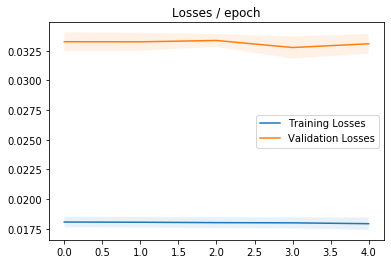

In [94]:
cv_plotter(cv_loss_trn, cv_loss_val)

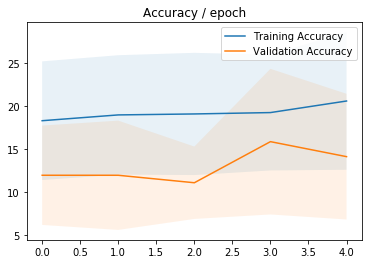

In [96]:
cv_plotter(cv_accs_trn, cv_accs_val, title='acc')

[]

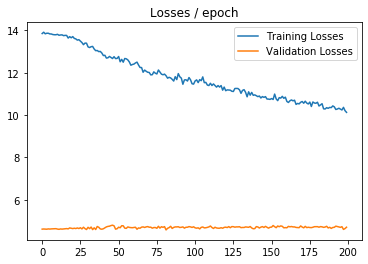

In [56]:
plt.title("Losses / epoch")
plt.plot(train_losses, label='Training Losses')
plt.plot(val_losses, label='Validation Losses')
plt.legend()
plt.plot()

[]

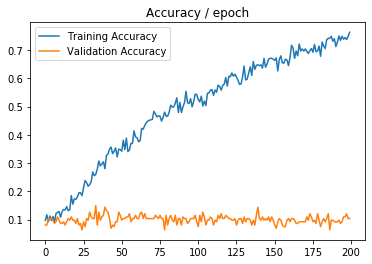

In [57]:
plt.title("Accuracy / epoch")
plt.plot(np.array(train_accs)/train_cnt, label='Training Accuracy')
plt.plot(np.array(val_accs)/val_cnt, label='Validation Accuracy')
plt.legend()
plt.plot()

In [55]:
conv(x).argmax(axis=1)

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 6, 1, 6, 7, 5, 0, 2, 6, 5, 2, 0, 8, 7, 8, 7, 6, 3, 8, 8, 3, 7, 5, 8,
        4, 6, 2, 8, 3, 3, 3, 1, 8, 3, 1, 1, 2, 1, 4, 3, 1, 6, 2, 9, 0, 1],
       grad_fn=<NotImplemented>)

In [1]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='binary')

EPOCHS = range(100)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_binary_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_binary_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

NameError: name 'ConvNet' is not defined

In [72]:
pred = torch.tensor([0.1, 0.2, 0.3, 0.9], dtype=torch.float)
true = torch.tensor([0, 0, 0, 1], dtype=torch.float)
loss_fn(pred, true)

tensor(0.1976)